# New York City Airbnb Analysis

## IST 652

### Caitlin Rookey, Allison Deming, and Patrick McIntee

We propose to analyze various Airbnb properties offered throughout New York City from the dataset available at Kaggle (https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data).  We will identify neighborhoods with the highest rate of return for potential property managers to invest in as well as the lowest priced neighborhoods for future customers looking to rent a property. We will use multiple measures of analysis as well as additional datasets such as New York City citywide crime statistics that we find relevant to rental prices in neighborhoods as reported in the New York City Open Data site (https://opendata.cityofnewyork.us/). 

In [1]:
#load all of the packages used for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords
import geopandas as gpd
from shapely.geometry import Point
from IPython.display import HTML, display
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [2]:
#program to import data from file
def import_dataset(data):
    main_df = pd.read_csv(data)
    return main_df

The first step in the analysis is to read in the datasets identified for analysis. For the purpose of our project, we are looking at Airbnb data, specifically room types and room rates for listings in New York City and compare our findings with New York Police Department data consisting of various reports and complaints as reported by citizens in NYC boroughs. 

In [3]:
#read in the two datasets for the analysis
airbnb_df = import_dataset('AB_NYC_2019.csv')
nypd_df = import_dataset('NYPD.csv')

The next step is to identify null values and provide a summarization of the datasets to get a high-level understanding of the data and where to focus our analysis:

In [4]:
#summarize the airbnb data
def summarize_data(data):
    data_summary = pd.DataFrame(data.dtypes, columns=["Data Type"])
    data_summary["Null Count"] = data.isnull().sum()
    data_summary["Unique Count"] = data.nunique()
    
    print("Summary of Data")
    print(data_summary)

In [5]:
summarize_data(airbnb_df)

summarize_data(nypd_df)

Summary of Data
                               Data Type  Null Count  Unique Count
id                                 int64           0         48895
name                              object          16         47905
host_id                            int64           0         37457
host_name                         object          21         11452
neighbourhood_group               object           0             5
neighbourhood                     object           0           221
latitude                         float64           0         19048
longitude                        float64           0         14718
room_type                         object           0             3
price                              int64           0           674
minimum_nights                     int64           0           109
number_of_reviews                  int64           0           394
last_review                       object       10052          1764
reviews_per_month                float64      

In [47]:
#a program to view the breakdown of a given field
def data_view(data, field):
    data_count = Counter(data[field]).most_common()
    data_df= pd.DataFrame(data_count)
    data_df.rename(columns={0:{field}, 1:"Count"}, inplace=True)
    print(f"{field} Summary:")
    print(data_df.to_markdown())

In [48]:
#this takes a look at the offense descriptions in the NYPD data to see what was being reported
data_view(nypd_df, 'OFNS_DESC')

OFNS_DESC Summary:
|    | {'OFNS_DESC'}                        |   Count |
|---:|:-------------------------------------|--------:|
|  0 | PETIT LARCENY                        |   53704 |
|  1 | HARRASSMENT 2                        |   41578 |
|  2 | ASSAULT 3 & RELATED OFFENSES         |   28420 |
|  3 | GRAND LARCENY                        |   24351 |
|  4 | CRIMINAL MISCHIEF & RELATED OF       |   20949 |
|  5 | FELONY ASSAULT                       |   13408 |
|  6 | VEHICLE AND TRAFFIC LAWS             |   11627 |
|  7 | OFF. AGNST PUB ORD SENSBLTY &        |    8977 |
|  8 | MISCELLANEOUS PENAL LAW              |    8449 |
|  9 | ROBBERY                              |    7808 |
| 10 | GRAND LARCENY OF MOTOR VEHICLE       |    7540 |
| 11 | BURGLARY                             |    6888 |
| 12 | DANGEROUS DRUGS                      |    6308 |
| 13 | SEX CRIMES                           |    4670 |
| 14 | DANGEROUS WEAPONS                    |    3999 |
| 15 | OFFENSES AGAINST PUBLI

Here we see that some of the main points from the summary is that we have almost 50,000 listings in all five boroughs (we see that there are six boroughs listed in NYPD data but we can use geocoordinates to identify where complaints are localized compared to airbnb listings). 

In [8]:
print("Airbnb Boroughs:", airbnb_df['neighbourhood_group'].unique().tolist())
print("NYPD Boroughs:", nypd_df['BORO_NM'].unique().tolist())

Airbnb Boroughs: ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']
NYPD Boroughs: ['BRONX', 'STATEN ISLAND', 'MANHATTAN', 'BROOKLYN', 'QUEENS', '(null)']


We see that the NYPD dataset has a borough named "(null)" which will affect the comparison later on. We will remove those null entries from the data.

In [9]:
#program to remove a string from a dataset
def remove_string(string, column, data):
    string_to_remove = string
    extracted_groups = nypd_df[column].str.extract(string_to_remove, expand=False)
    mask = extracted_groups.isna()
    data = data[mask]
    return data

In [10]:
nypd_df = remove_string('(null)', 'BORO_NM', nypd_df)

In [11]:
#next we will look at statistics on the airbnb numerical data
data_stats = airbnb_df[['price', 'minimum_nights','number_of_reviews', 'calculated_host_listings_count']].describe()
#print(summary_stats)
print("Summary Statistics for the numerical values")
print(data_stats.to_markdown())

Summary Statistics for the numerical values
|       |     price |   minimum_nights |   number_of_reviews |   calculated_host_listings_count |
|:------|----------:|-----------------:|--------------------:|---------------------------------:|
| count | 48895     |      48895       |          48895      |                      48895       |
| mean  |   152.721 |          7.02996 |             23.2745 |                          7.14398 |
| std   |   240.154 |         20.5105  |             44.5506 |                         32.9525  |
| min   |     0     |          1       |              0      |                          1       |
| 25%   |    69     |          1       |              1      |                          1       |
| 50%   |   106     |          3       |              5      |                          1       |
| 75%   |   175     |          5       |             24      |                          2       |
| max   | 10000     |       1250       |            629      |            

Here we see that the overall average price of a listing in NYC is $152.72 with the listing with an average of 24.27 reviews.

In [12]:
rooms_category = airbnb_df.groupby('room_type')

# Calculate summary statistics for each category
rooms_category = rooms_category.agg({
    'price': 'mean',
    'minimum_nights': 'mean',
    'number_of_reviews': 'mean',
    'reviews_per_month': 'mean',
    'calculated_host_listings_count': 'mean'
}).reset_index()

# Display the room category statistics
print("Summary Statistics by room Category:")
print(rooms_category.to_markdown(index=False))

Summary Statistics by room Category:
| room_type       |    price |   minimum_nights |   number_of_reviews |   reviews_per_month |   calculated_host_listings_count |
|:----------------|---------:|-----------------:|--------------------:|--------------------:|---------------------------------:|
| Entire home/apt | 211.794  |          8.50691 |             22.8424 |             1.30658 |                         10.6983  |
| Private room    |  89.781  |          5.3779  |             24.113  |             1.44521 |                          3.22772 |
| Shared room     |  70.1276 |          6.475   |             16.6    |             1.47173 |                          4.66293 |


We see that room types have a distinct effect on average price with entire homes over 2x the average price of both private rooms and shared room. We also see that private rooms have a higher number of reviews.

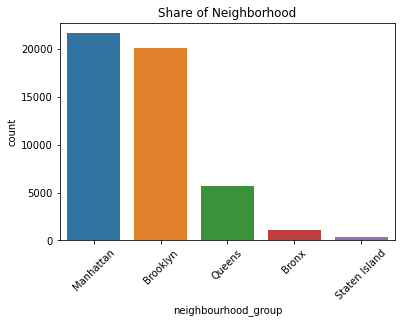

In [13]:
#Taking a closer look at the neighborhood catagories
ax = sns.countplot(x='neighbourhood_group', data=airbnb_df, order=airbnb_df['neighbourhood_group'].value_counts().index)
ax.set_title('Share of Neighborhood')
plt.xticks(rotation=45)  # Rotate x-labels for better readability if needed
plt.show()

We see that Manhattan and Brooklyn make up the vast majority of listings in the dataset.

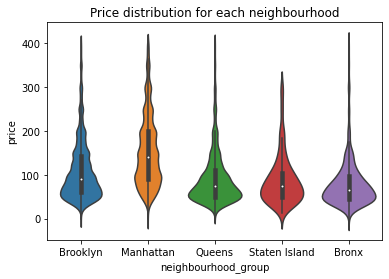

In [14]:
#Creating a violin plot to examine the price distribution for each neighborhood. In our final project we will be analyzing how crime data impacts these prices and availability.
winsorized_df=airbnb_df[airbnb_df.price < 400]

# using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(data=winsorized_df, x='neighbourhood_group', y='price')
viz_2.set_title('Price distribution for each neighbourhood')
plt.show()

Here we have a price distribution of the boroughs - Manhattan has a higher variation of prices, whereas Queens and Bronx are closely centered around the mean. 

neighbourhood_group
Manhattan        196.88
Brooklyn         124.38
Staten Island    114.81
Queens            99.52
Bronx             87.50
Name: price, dtype: float64




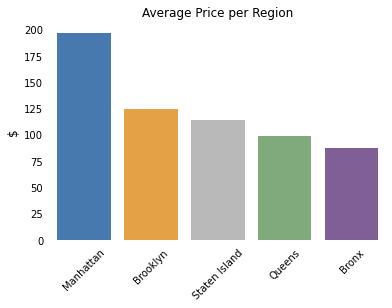

In [15]:
#Using Seaborn, again, to look at the average prices per neighborhood

# Calculating the average price per region
price_region = round(airbnb_df.groupby('neighbourhood_group').price.mean().sort_values(ascending=False), 2)

# Displaying the results
print(price_region)
print('\n')

# Define a color palette
colors = ["#3778bf", "#ffa52c", "#b9b9b9", "#7bb274", "#8256a0"]

# Create the bar plot using Seaborn
ax = sns.barplot(x=price_region.index, y=price_region.values, palette=colors)
ax.set_title('Average Price per Region')
ax.tick_params(bottom=False, top=False, left=False, right=False)
ax.set_ylabel('$', fontsize=12)
ax.set_xlabel('')
for key, spine in ax.spines.items():
    spine.set_visible(False)

plt.xticks(rotation=45)
plt.show()

Finally, we look at average price by neighborhood and see that Manhattan has the highest average price per listing at almost $200 with Brooklyn at $125 and the remaining boroughs closer to $100.

From our summary view, we can identify our next step which to see what boroughs have the highest and lowest average listing price and compare with complaint data to see if higher number of complaints (ie a noisy or violent neighborhood) can lead to a decreased listing value. In addition to average price, we will plot airbnb listings with NYPD complaints to see if there are geographic concentrations that we should avoid as a property owner or potential Airbnb patron. 

### Hypothesis #1

We think that neighborhoods with higher volumes of NYPD complaints will lead to lower listing values. To test this hypothesis, we will look at average listing price for neighborhoods and look at the rate of complaints for each borough to see if there is a relationship.

In [16]:
def group_data(data, group, value, calc):
    # Group the data by the 'neighbourhood' column
    neighbourhood_groups = data.groupby(group)

    # Calculate summary statistics for each neighbourhood_groups
    category_summary = neighbourhood_groups.agg({
        value:calc}).reset_index()

    return category_summary


In [17]:
bnb_summary = group_data(airbnb_df, 'neighbourhood_group', 'price', 'mean')
nypd_summary = group_data(nypd_df, 'BORO_NM', 'CMPLNT_NUM', 'count')

In [18]:
def plot_group(data, group, value):
    plt.figure(figsize=(12, 6))
    colors = ['blue', 'black']

    # Plot of the mean price by neighbourhood group
    plt.subplot(2, 2, 1)
    plt.bar(data[group], data[value], color=colors[0])
    plt.title(f"{value} by {group}")
    plt.xlabel(f"{group}")
    plt.ylabel(f"{value}")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

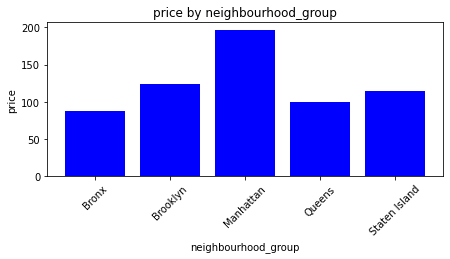

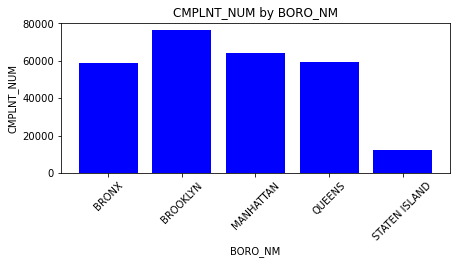

In [19]:
plot_group(bnb_summary, 'neighbourhood_group', 'price')
plot_group(nypd_summary, 'BORO_NM', 'CMPLNT_NUM')

### Result

By looking at the average listing price for NYC boroughs and comparing to the number of criminal complaints for the same boroughs, we can see that while Manhattan has the highest listing price, for complaints it appears to be second behind Brooklyn. This appears to be inconsistent as Brooklyn has the second highest average listing price, but has the most complaints. This discrepancy may be explained by the fact that we are comparing too large of an area and need to be more precise in comparing Airbnb listings to various complaints.

### Hypothesis #2

We think that concentrations of complaints indicative of noisy or violent neighborhoods, will lead to lower numbers of listings for that given neighborhood. To test this hypothesis, we will plot the Airbnb listings to a map of NYC and overlay a plot of complaints to see there are neighborhoods with higher levels of crime and low numbers of listings.

In [20]:
# Load GeoJSON data
geojson_path = 'boroughs.geojson'
geo_df = gpd.read_file(geojson_path)

In [21]:
def important_columns(column_names, data):
    columns = []
    for column in column_names:
        columns.append(column)
    
    data_imp = data[columns]

    return data_imp

In [22]:
airbnb_imp = important_columns(('id', 'name', 'longitude', 'latitude', 'neighbourhood_group', 'neighbourhood', 'room_type'), data=airbnb_df)
nypd_imp = important_columns(('Longitude', 'Latitude', 'BORO_NM', 'OFNS_DESC', 'LAW_CAT_CD'), data=nypd_df)

In [23]:
# Create a GeoDataFrame for Airbnb data
def create_geo_df(data, long, lat):
    geometry_df = [Point(xy) for xy in zip(data[long], data[lat])]
    geo_df = gpd.GeoDataFrame(data, geometry=geometry_df)
    return geo_df

In [24]:
airbnb_geo_df = create_geo_df(airbnb_imp, 'longitude', 'latitude')
nypd_geo_df = create_geo_df(nypd_imp, 'Longitude', 'Latitude')

In [25]:
#check geo dataframes
print(airbnb_geo_df.head())

     id                                              name  longitude  \
0  2539                Clean & quiet apt home by the park  -73.97237   
1  2595                             Skylit Midtown Castle  -73.98377   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !  -73.94190   
3  3831                   Cozy Entire Floor of Brownstone  -73.95976   
4  5022  Entire Apt: Spacious Studio/Loft by central park  -73.94399   

   latitude neighbourhood_group neighbourhood        room_type  \
0  40.64749            Brooklyn    Kensington     Private room   
1  40.75362           Manhattan       Midtown  Entire home/apt   
2  40.80902           Manhattan        Harlem     Private room   
3  40.68514            Brooklyn  Clinton Hill  Entire home/apt   
4  40.79851           Manhattan   East Harlem  Entire home/apt   

                     geometry  
0  POINT (-73.97237 40.64749)  
1  POINT (-73.98377 40.75362)  
2  POINT (-73.94190 40.80902)  
3  POINT (-73.95976 40.68514)  
4  POINT (

In [26]:
print(nypd_geo_df.head())

   Longitude   Latitude        BORO_NM                        OFNS_DESC  \
0 -73.848929  40.822882          BRONX                          ROBBERY   
1        NaN        NaN  STATEN ISLAND  MURDER & NON-NEGL. MANSLAUGHTER   
2 -73.903374  40.867300          BRONX                    HARRASSMENT 2   
3 -73.945123  40.815904      MANHATTAN                    PETIT LARCENY   
4 -73.943126  40.826268      MANHATTAN    OFF. AGNST PUB ORD SENSBLTY &   

    LAW_CAT_CD                    geometry  
0       FELONY  POINT (-73.84893 40.82288)  
1       FELONY                 POINT EMPTY  
2    VIOLATION  POINT (-73.90337 40.86730)  
3  MISDEMEANOR  POINT (-73.94512 40.81590)  
4  MISDEMEANOR  POINT (-73.94313 40.82627)  


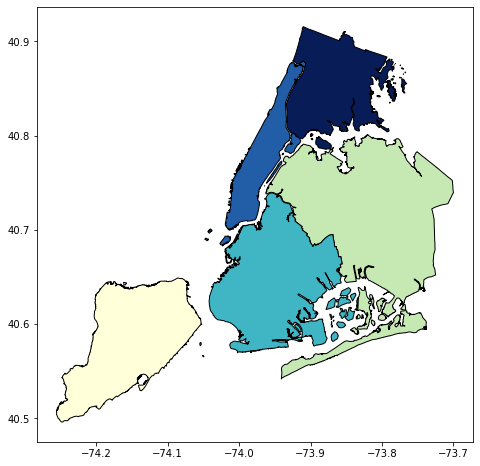

In [27]:
# Create your base map using GeoPandas
ax_map = geo_df.plot(figsize=(12, 8), edgecolor='k', cmap='YlGnBu')

In [28]:
# Add NYPD complaints as separate markers
def add_complaint_markers():
    for index, row in nypd_geo_df.iloc[:1000].iterrows():
        if row['LAW_CAT_CD'] == 'FELONY':
            color = 'red'
        elif row['LAW_CAT_CD'] == 'VIOLATION':
            color = 'blue'
        else:
            color = 'green'
        ax_map.scatter(row['Longitude'], row['Latitude'], color=color, marker='o', s=10)

In [29]:
# Add Airbnb listings as markers
def add_airbnb_listings():
    for index, row in airbnb_geo_df.iloc[:1000].iterrows():
        ax_map.scatter(row['longitude'], row['latitude'], color='orange', marker='o', s=10)

In [30]:
add_complaint_markers()
add_airbnb_listings()

In [31]:
# Display the map
plt.show()

In [32]:
ax_map.legend(['FELONY', 'VIOLATION', 'MISDEMEANOR', 'Airbnb Listings'])

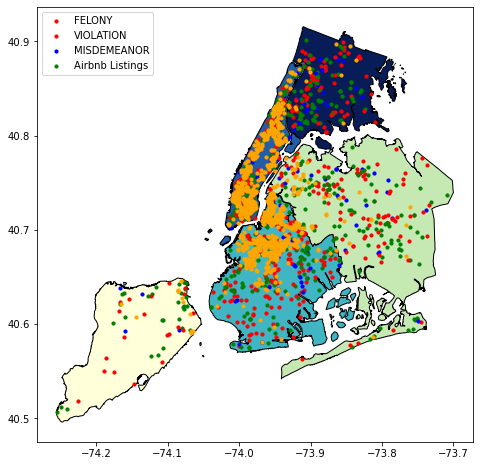

In [33]:
ax_map.get_figure()

### Result

From the map plot we can see that the Airbnb listings are largely concentrated within the island of Manhattan and Brooklyn (as we found in our summarization in part I). The complaints are largely spread throughout the boroughs with many more complaints in Queens and the Bronx than there are Airbnb listings - likely driving those overall numbers in the previous view. 

### Hypothesis #3

We think that language used in the listing's description may influence the price as more positive sounding words would increase the price and negative connotations could decrease the price. To test our hypothesis, we will use natural language analysis to determine the sentiment of words used in the description and see if there is any correlation on price. 

In [34]:
#create a list of words from the listing name field
def create_list(data, column):
    names = data[column].tolist()
    name_words = []
    for name in names:
        name = str(name).split()
        for word in name:
            name_words.append(word.lower())
    filtered_words = [word for word in name_words if word not in stopwords.words('english')]
 
    return filtered_words

In [35]:
bnb_word_list = create_list(airbnb_df, 'name')

In [36]:
text = " ".join(bnb_word_list)

In [37]:
# Create a WordCloud object to visually represent the listing words
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

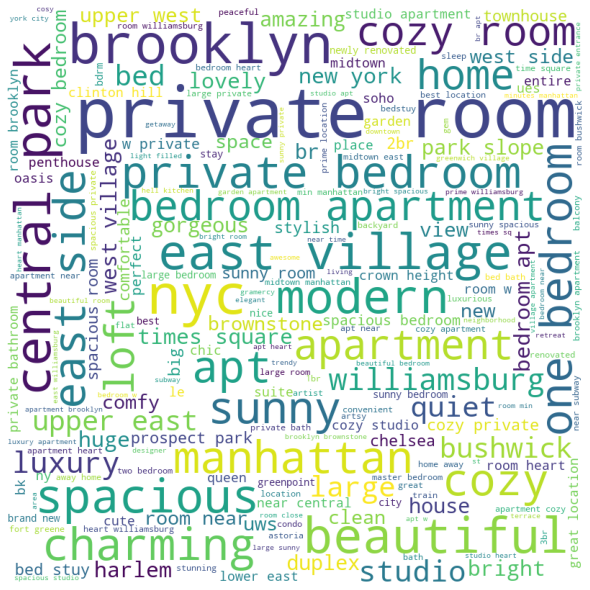

In [38]:
# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [39]:
#Additionally, we can tabulate the words to identify the most used
words_count = Counter(bnb_word_list).most_common()
words_count = words_count[:25]
words_df = pd.DataFrame(words_count)
words_df.head()
words_df.rename(columns={0:"Words", 1:"Count"}, inplace=True)

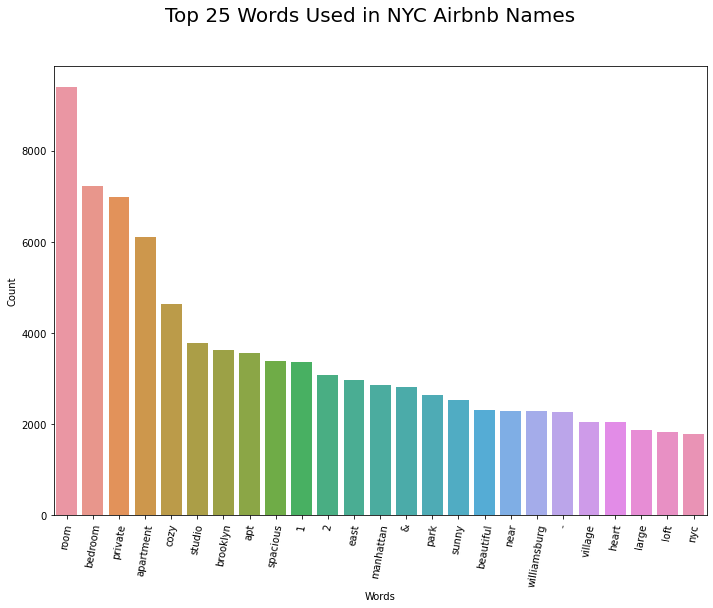

In [40]:
#barplot with top 25 words used
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
fig.suptitle('Top 25 Words Used in NYC Airbnb Names', fontsize=20)
sns.barplot(x='Words', y='Count', data=words_df, ax=ax)
plt.xticks(rotation=80)
plt.show()

From the wordcloud and the bar chart, we can see that words such as private, cozy, apartment, room are all used with the most frequency. We will now look at the relationship of the words used and the price of the listing.

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [42]:
def sentiment_analysis(data, column, value):
    # preparing an array that we will use as data for our dataframe
    df = []
    for i,row in data.iterrows():
    # we want to create a dictionary that stores the name and price of a property, as well as the neutral, positive, and
    # compound scores that were returned by NLTK.
        dic = {}
        ss = sid.polarity_scores(str(row[column]))
    
        dic[column] = row[column]
        dic['sentiment_neu'] = ss['neu']
        dic['sentiment_pos'] = ss['pos']
        dic['sentiment_compound'] = ss['compound']
        dic[value] = row[value]
        df.append(dic)
    
    sentiment_df = pd.DataFrame(df)
    return sentiment_df

In [43]:
bnb_sentiment = sentiment_analysis(airbnb_df, 'name', 'price')
bnb_sentiment.head()

,name,sentiment_neu,sentiment_pos,sentiment_compound,price
0,Clean & quiet apt home by the park,0.69,0.31,0.4019,149
1,Skylit Midtown Castle,1.00,0.00,0.0000,225
2,THE VILLAGE OF HARLEM....NEW YORK !,1.00,0.00,0.0000,150
3,Cozy Entire Floor of Brownstone,1.00,0.00,0.0000,89
4,Entire Apt: Spacious Studio/Loft by central park,1.00,0.00,0.0000,80


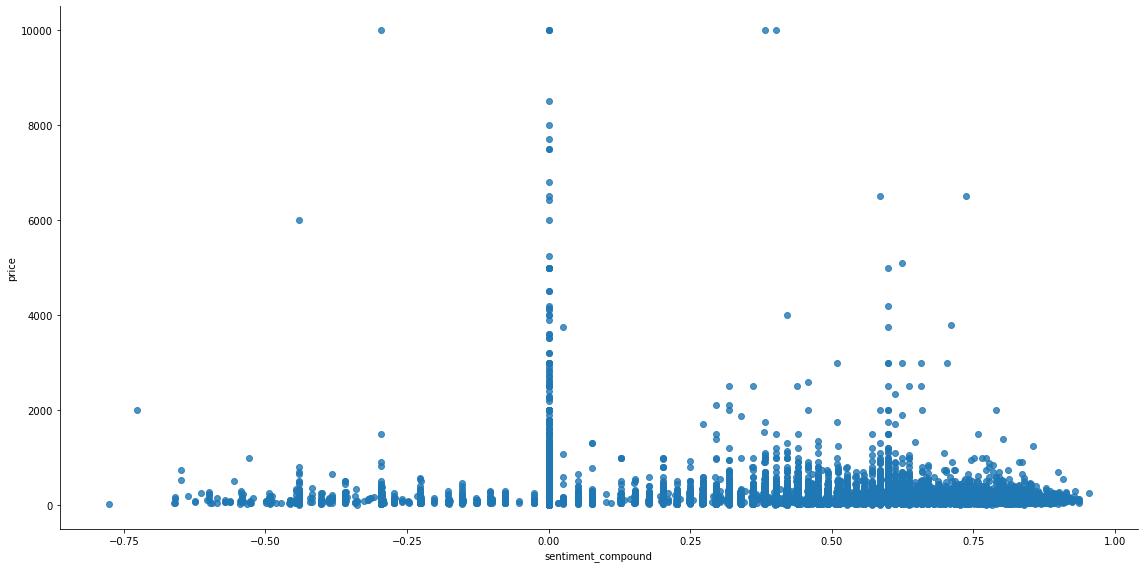

In [44]:
sns.lmplot(x='sentiment_compound', y='price', data=bnb_sentiment, fit_reg=False, height=8, aspect=2)

### Result

Intuitively, we see that the most frequently used words in the listing description are words describing the room itself (bedroom, room, apartment, studio, etc), but also descriptions such as cozy, private, spacious, etc that evoke a sense of security in a large city such as New York. Interestingly, there is no mention of safe, secure, clean, or any terms that would evoke a sense of security. Finally, by looking at the sentiment associated with the words used, we do see that words that have a positive meaning tend to lead to higher listing prices. 

### Conclusion

The correlation between Airbnb listing prices and the rate of criminal complaints in a given neighborhood is a multifaceted and complex relationship. While some degree of correlation may exist, it is important to recognize that numerous factors can influence both Airbnb prices and crime rates independently. Neighborhoods with higher crime rates may, in some cases, experience lower Airbnb prices due to decreased demand for short-term rentals. Conversely, neighborhoods with lower crime rates might attract more visitors, leading to higher Airbnb prices. However, it is essential to exercise caution when drawing direct causal relationships, as numerous other socioeconomic, cultural, and environmental factors can also impact both Airbnb pricing and criminal activity within a neighborhood. A comprehensive analysis would require a nuanced examination of various contributing variables to gain a more accurate understanding of this correlation.